In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ROOT as rt
from ROOT import TFile, TTree, TCanvas, TH2D, TH1F
from scipy import constants

Welcome to JupyROOT 6.22/09


In [2]:
f = TFile("selectedEventsTrueRecoBoth_withTrueTrkDir_withParticleEs_111124.root","READ")
t = f.Get("selectedEvents")

entries = t.GetEntries()
print(entries)

10913


In [3]:
t.GetEntry(5)

def getTransverseAxis(eNu, pxMu, pyMu, pzMu):
    pV = np.array([0, 0, eNu])
    pMu = np.array([pxMu, pyMu, pzMu])
    z = np.cross(pV, pMu)
    magZ = np.sqrt( z[0]**2 + z[1]**2 + z[2]**2 )
    #return z / magZ
    return z / np.linalg.norm(z) # same as my magZ eqn above

print(t.recoSel_recoNuE_)
print(t.recoSel_trkDirMuX_)
print(t.recoSel_trkDirMuY_)
print(t.recoSel_trkDirMuZ_)

z = getTransverseAxis(t.recoSel_recoNuE_,t.recoSel_trkDirMuX_,t.recoSel_trkDirMuY_,t.recoSel_trkDirMuZ_)

print("z: ", z )

0.48742047119140625
0.053709817209715204
-0.13113712865486582
0.21879997807629656
z:  [ 0.92539155  0.3790125  -0.        ]


In [4]:
t.GetEntry(5)

pPi = np.array([t.recoSel_trkDirPiX_, t.recoSel_trkDirPiY_, t.recoSel_trkDirPiZ_])
pP = np.array([t.recoSel_trkDirPX_, t.recoSel_trkDirPY_, t.recoSel_trkDirPZ_])
print(pPi)
print(pP)

# 1st TKI observable, double-transverse momentum imbalance
def delPTT(z, pPi, pP): 
    pPiTT = np.dot(z,pPi)
    pPTT = np.dot(z,pP)
    return pPiTT + pPTT

print( delPTT(z, pPi, pP) )

[-0.10935544 -0.04122055 -0.01128636]
[-0.21189227  0.00324651  0.37416956]
-0.3116725511591243


In [5]:
t.GetEntry(5)

# sum of transverse momenta of the 3 particles
def delPT(pxPi, pxP, pxMu, pyPi, pyP, pyMu): 
    pTMu = np.array([pxMu, pyMu, 0])
    pTP = np.array([pxP, pyP, 0])
    pTPi = np.array([pxPi, pyPi, 0])
    return pTMu + pTPi + pTP

delPT_test = delPT(t.recoSel_trkDirPiX_, t.recoSel_trkDirPX_, t.recoSel_trkDirMuX_, t.recoSel_trkDirPiY_, t.recoSel_trkDirPY_, t.recoSel_trkDirMuY_)
print(delPT_test)

[-0.26753789 -0.16911117  0.        ]


In [6]:
t.GetEntry(5)

epsilon = 0.0309

# longitudinal component, the long way
def pL(pzP, pzMu, pzPi, eP, eMu, ePi, delPT): 
    mP = constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000 
    #print("mP: ", mP)
    mN = constants.physical_constants['neutron mass energy equivalent in MeV'][0]/1000
    #print("mN: ", mN)
    B = 0.34381
    mA = 22*mN + 18*mP - B
    mA1 = mA - mN + epsilon
    del2 = np.dot(delPT, delPT)
    #pLP = np.array([0, 0, pzP])
    #pLMu = np.array([0, 0, pzMu])
    #pLPi = np.array([0, 0, pzPi])
    parens = mA + pzMu + pzPi + pzP - eMu - ePi - eP
    return 0.5*(parens) - 0.5*((del2+mA1**2)/(parens))

pL_test = pL(t.recoSel_trkDirPZ_, t.recoSel_trkDirMuZ_, t.recoSel_trkDirPiZ_, t.recoSel_eP_, t.recoSel_eMu_, t.recoSel_ePi_, delPT_test)
#print(t.pzP_)
print("pL_test: ", pL_test)

def pLGKI(pzP, pzMu, pzPi, eP, eMu, ePi):
    pRest = constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000
    piRest = 139.57/1000 # GeV
    #print("piRest:", piRest)
    #Ecal = eMu + (eP-pRest) + (ePi-piRest) + epsilon
    Ecal = eMu + (eP-pRest) + ePi + epsilon
    return pzMu + pzP + pzPi - Ecal

pLGKI_test = pLGKI(t.recoSel_trkDirPZ_, t.recoSel_trkDirMuZ_, t.recoSel_trkDirPiZ_, t.recoSel_eP_, t.recoSel_eMu_, t.recoSel_ePi_)
print("pLGKI_test: ", pLGKI_test)

pL_test:  -0.006847073443509544
pLGKI_test:  -0.006760224706575335


In [7]:
# 3rd TKI observable, boosting angle
def delAlphaT(pxMu, pyMu, delPT): 
    pTMu = np.array([pxMu, pyMu, 0])
    magPTMu = np.sqrt( pTMu[0]**2 + pTMu[1]**2 + pTMu[2]**2 )
    magDelPT = np.sqrt( delPT[0]**2 + delPT[1]**2 + delPT[2]**2 )
    dot = np.dot(-pTMu,delPT)
    return np.arccos(dot / (magPTMu * magDelPT))

delAlphaT_test = delAlphaT(t.recoSel_trkDirMuX_, t.recoSel_trkDirMuY_, delPT_test)
print(delAlphaT_test)

1.7457572653823448


In [8]:
# make efficiency plot in terms of: truth_pN

h_plotvar_true = []
h_plotvar_trueAndReco = []
h_plotvar_reco = []

truth_weights = []
both_weights = []

completeness = 0.5

for e in range(entries):

    t.GetEntry(e)
    
    if (t.passedSel_ == 1) or (t.passedSel_ == 3): # passes truth selection
        
        pPi = np.array([t.truthSel_pxPi_, t.truthSel_pyPi_, t.truthSel_pzPi_])
        pP = np.array([t.truthSel_pxP_, t.truthSel_pyP_, t.truthSel_pzP_])
    
        z = getTransverseAxis(t.truthSel_eNu_,t.truthSel_pxMu_,t.truthSel_pyMu_,t.truthSel_pzMu_)
        
        truth_delPTT = delPTT(z, pPi, pP)
        
        truth_delPT_entry = delPT(t.truthSel_pxPi_, t.truthSel_pxP_, t.truthSel_pxMu_, t.truthSel_pyPi_, t.truthSel_pyP_, t.truthSel_pyMu_)

        truth_pL_entry = pL(t.truthSel_pzP_, t.truthSel_pzMu_, t.truthSel_pzPi_, t.truthSel_eP_, t.truthSel_eMu_, t.truthSel_ePi_, truth_delPT_entry)
        truth_pN = np.sqrt( np.dot(truth_delPT_entry, truth_delPT_entry) + np.dot(truth_pL_entry, truth_pL_entry) )

        truth_delAlphaT_entry = delAlphaT(t.truthSel_pxMu_, t.truthSel_pyMu_, truth_delPT_entry)
    
        h_plotvar_true.append(truth_delPTT)
        
        truth_weights.append(t.weight_)
        
    #if (t.passedSel_ == 3) and (t.recoSel_trackCompMu_ > completeness) and (t.recoSel_trackCompPi_ > completeness) and (t.recoSel_trackCompP_ > completeness): # passes both reco and truth selection
    if (t.passedSel_ == 3) and (t.recoSel_trackCompMu_ > completeness) and (t.recoSel_trackCompPi_ > completeness) and (t.recoSel_trackCompP_ > completeness) and (t.recoSel_recoContained_==2): # passes both reco and truth selection

        
        h_plotvar_trueAndReco.append(truth_delPTT)
        
        both_weights.append(t.weight_)
        
        
#    if (t.passedSel_ == 2) or (t.passedSel_ == 3): # passes reco selection
#        h_reco.append(t.truthSel_truthMuonMom_)
            
#print("h_true: ", h_true)
print("len(h_true): ", len(h_plotvar_true))

#print("h_trueAndReco: ", h_trueAndReco)
print("len(h_trueAndReco): ", len(h_plotvar_trueAndReco))

#print("len(h_reco): ", len(h_reco))

true_arr = np.asarray(h_plotvar_true)
trueAndReco_arr = np.asarray(h_plotvar_trueAndReco)
truth_weight_arr = np.asarray(truth_weights)
both_weight_arr = np.asarray(both_weights)

print(np.sum(truth_weight_arr))
print(np.sum(both_weight_arr))

print("overall efficiency: ", (np.sum(both_weight_arr)) / (np.sum(truth_weight_arr))*100)


len(h_true):  9964
len(h_trueAndReco):  483
9977.248706321412
480.3657590386961
overall efficiency:  4.814611454301472


maxTruth:  0.9874523079886299
true hist:  [   5   38  276 1142 3611 3477 1102  279   30    4]
total true hist:  9964
bins1:  [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
both hist:  [  0   2  11  45 171 192  47  12   2   1]
total both hist:  483
bins2:  [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
hist_ratio:  [0.         0.05263158 0.03985507 0.03940455 0.0473553  0.05522002
 0.04264973 0.04301075 0.06666667 0.25      ]
hist_ratio: [0.         0.05263158 0.03985507 0.03940455 0.0473553  0.05522002
 0.04264973 0.04301075 0.06666667 0.25      ]
sum hist ratio:  0.6367936724450867


Text(0.5, 1.0, 'Efficiency in delPTT')

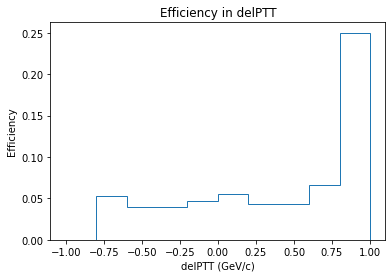

In [9]:
numberBins = 10
maxTruth = np.max(true_arr)
print("maxTruth: ", maxTruth)

np.seterr(divide='ignore', invalid='ignore')
binEdgeRange = (-1, 1)

#true_arr = true_arr*(180/np.pi)
#trueAndReco_arr = trueAndReco_arr*(180/np.pi)

# Create histograms
hist1, bins1 = np.histogram(true_arr, bins=numberBins, range=binEdgeRange)
hist2, bins2 = np.histogram(trueAndReco_arr, bins=numberBins, range=binEdgeRange)

if len(hist1) != len(hist2):
    raise ValueError("Histograms must have the same number of bins")
    
print("true hist: ", hist1)
print("total true hist: ", np.sum(hist1) )
print("bins1: ", bins1)
print("both hist: ", hist2)
print("total both hist: ", np.sum(hist2) )
print("bins2: ", bins2)

    
# Divide histograms
hist_ratio = hist2 / hist1

print("hist_ratio: ", hist_ratio)

# Handle division by zero
hist_ratio = np.nan_to_num(hist_ratio)  # Replace NaN with 0 or another value

print("hist_ratio:", hist_ratio)
print("sum hist ratio: ", np.sum(hist_ratio) )

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)
plt.stairs(hist_ratio, bins1, label="1.3e21 POT (data, all runs)")

plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Efficiency')
plt.title('Efficiency in delPTT')

In [10]:
numberBins = 100
maxReco = np.max(reco_arr)
print("maxTruth: ", maxReco)

np.seterr(divide='ignore', invalid='ignore')
binEdgeRange = (-1, 1)

# Create histograms
hist1, bins1 = np.histogram(reco_arr, bins=numberBins, range=binEdgeRange)
hist2, bins2 = np.histogram(trueAndReco_arr, bins=numberBins, range=binEdgeRange)

if len(hist1) != len(hist2):
    raise ValueError("Histograms must have the same number of bins")
    
print("reco hist: ", hist1)
print("total reco hist: ", np.sum(hist1) )
print("bins1: ", bins1)
print("both hist: ", hist2)
print("total both hist: ", np.sum(hist2) )
print("bins2: ", bins2)

    
# Divide histograms
hist_ratio = hist2 / hist1

print("hist_ratio: ", hist_ratio)

# Handle division by zero
hist_ratio = np.nan_to_num(hist_ratio)  # Replace NaN with 0 or another value

print("hist_ratio:", hist_ratio)
print("sum hist ratio: ", np.sum(hist_ratio) )

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)
plt.stairs(hist_ratio, bins1, label="1.3e21 POT (data, all runs)")

NameError: name 'reco_arr' is not defined

In [ ]:
c1 = TCanvas("c1","c1",720,152,682,505)
c1.cd()
h_true.Draw("")

c1.Draw()

In [ ]:
targetPOT = 1.3e21
simPOT = 4.68e20 # this is for run 1

h_trueAndReco.Scale(targetPOT/simPOT)
h_true.Scale(targetPOT/simPOT)

In [ ]:
h_eff = h_trueAndReco.Clone("h_eff")
h_eff.Divide(h_true)

h_eff.GetXaxis().SetTitle("Truth Muon Momentum [GeV]")

canvas = TCanvas("canvas","canvas",720,152,682,505)
canvas.cd()
h_eff.Draw("")

canvas.Draw()

#outfile = rt.TFile("plots.root","RECREATE")
#canvas.Write()

